In [1]:
import pickle
import pywt
import glob
import subprocess

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

from scipy import signal, stats
from scipy.signal import savgol_filter, medfilt

from numpy.linalg import norm

%matplotlib inline

framerate = 29.97002997002997
diam_pool_param = 122 # in mm
thick_pool_wall_param = 4 # in mm

### function to smooth the speed vector

In [2]:
def speed_filter(speed_arr, thr=2, leftedge=-3, rightedge=-1, sgwindow=35, sgorder=3):
# the function first remove spikes from speed by averaging their value with that of the left-to-rightedge window:
# if pt(N) is a spike, it makes the average of the function at points left-to-right edge (typical right edge = -1, that is the point right before the spike at N)
# then apply sav_gol filter to return a smoothed vector
    dsp=np.diff(speed_arr)
    for ee in range(leftedge,len(dsp)):
# leftedge serves to skip avereage iver the firsts points and to avoid error
        if np.abs(dsp[ee]) >= thr:
            speed_arr[ee+1] = np.mean(speed_arr[ee+leftedge:ee+rightedge])
        else:
            speed_arr[ee] = speed_arr[ee]
    return savgol_filter(speed_arr, sgwindow, sgorder)

### function to smooth the cosine similarity vector

In [3]:
def cosine_filter(cos_arr, filter=True, thr=15, leftedge=-3, rightedge=-1, sgwindow=35, sgorder=3):
# the function first remove spikes by averaging their value with that of the left-to-rightedge window:
# if pt(N) is a spike, it makes the average of the function at points left-to-right edge (typical right edge = -1, that is the point right before the spike at N)
# then apply sav_gol filter to return a smoothed vector
    for ee in range(-1*leftedge,len(cos_arr)):
# leftedge serves to skip avereage over the firsts points and to avoid error
        if np.abs(cos_arr[ee]) >= thr:
            cos_arr[ee] = np.mean(cos_arr[ee+leftedge:ee+rightedge])
        else:
            cos_arr[ee] = cos_arr[ee]
    if filter == True:
        return savgol_filter(cos_arr,sgwindow, sgorder)
    elif filter == False:
        return cos_arr    

### import dataset

In [4]:
#filelist = glob.glob('./finals/10mm_eta-inA_[0-9]*di10.pkl')
filelist = glob.glob('S_eta-inA_1di10.pkl')
print(f'Number of files: {len(filelist)}')
print('File list:')
filelist

Number of files: 1
File list:


['S_eta-inA_1di10.pkl']

In [5]:
rototrans = True
coords =[]
pool_coord = []
rotation = []
for ff in filelist:
    with open(ff,'rb') as f:
        data = pickle.load(f)

    if len(data) == 5:
        coords.append(data[0])
        pool_coord.append([ [data[3][ff]] for ff in range(len(data[3])) ])
        if len(data[4]) != 0:
            rotation.append(data[4])
        else:
            print('Only translational movement')
            rototrans = False
    else:
        print('WRONG INPUT FILE!!')

In [6]:
minrow = []
maxrow = []
mincol = []
maxcol = []
# keep this structure as it allow for loading of multiple experiments!
for tt in range(len(pool_coord)):
    minrow.append([pool_coord[tt][gg][0]['minrow'] for gg in range(len(pool_coord[0]))])
    maxrow.append([pool_coord[tt][gg][0]['maxrow'] for gg in range(len(pool_coord[0]))])
    mincol.append([pool_coord[tt][gg][0]['mincol'] for gg in range(len(pool_coord[0]))])
    maxcol.append([pool_coord[tt][gg][0]['maxcol'] for gg in range(len(pool_coord[0]))])

# structure of the data:
- data (LIST) contains the raw data from video analysis:
- Each experiment is divided into chunks (typ 511 of 100 frames each) during the analysis
- each chunk contains 4 fields:
    1. an array with the swimmer coords (typ shape 100,2)
    2. an array with missed frames
    3. a list with a dictionary (!) with: threshold, min and max rows and cols of the pool position

- coords (LIST) contains N arrays with the swimmer coords for the N experiments loaded into this ipynb

# SELECT THE EXP NUMBER

In [49]:
# select the experiment number from a list of (possibly) multiple experiments
exp_num = 0
# select frames range (first hundreds of frames might contains unwanted objects)
init,fin = 20000, 22000

ave_maxcol = np.mean(maxcol[exp_num])
ave_mincol = np.mean(mincol[exp_num])
ave_maxrow = np.mean(maxrow[exp_num])
ave_minrow = np.mean(minrow[exp_num])

std_maxcol = np.std(maxcol[exp_num])
std_mincol = np.std(mincol[exp_num])
std_maxrow = np.std(maxrow[exp_num])
std_minrow = np.std(minrow[exp_num])

# Average pool size (in px)
pool_width = ave_maxcol - ave_mincol
pool_width_std = std_mincol + std_maxcol
pool_height = ave_maxrow - ave_minrow

pool_height_std = std_maxrow + std_minrow

print(f'{pool_width:.1f} +/- {pool_width_std:.1f}')
print(f'{pool_height:.1f} +/- {pool_height_std:.1f}')
pool_diam_px =(pool_width+pool_height)/2
px2mm = pool_diam_px / diam_pool_param
print(f'Pool Diam (px): {pool_diam_px:.1f}')
print(f'Pixel2mm(mm): {px2mm:.1f}')

1010.0 +/- 0.0
1005.5 +/- 0.5
Pool Diam (px): 1007.8
Pixel2mm(mm): 8.3


In [50]:
x_c = [] # these cannot be an array since different exps might have different pts
y_c = []
square_displ = []
speed = []
for rr in range(len(coords)):
    x_c.append(coords[rr][:,0])
    y_c.append(coords[rr][:,1])
    squared_displ = np.diff(coords[rr],axis=0)**2
# speed in mm/s
    speed.append(np.sqrt(np.sum(squared_displ, axis=1)) / px2mm)

[]

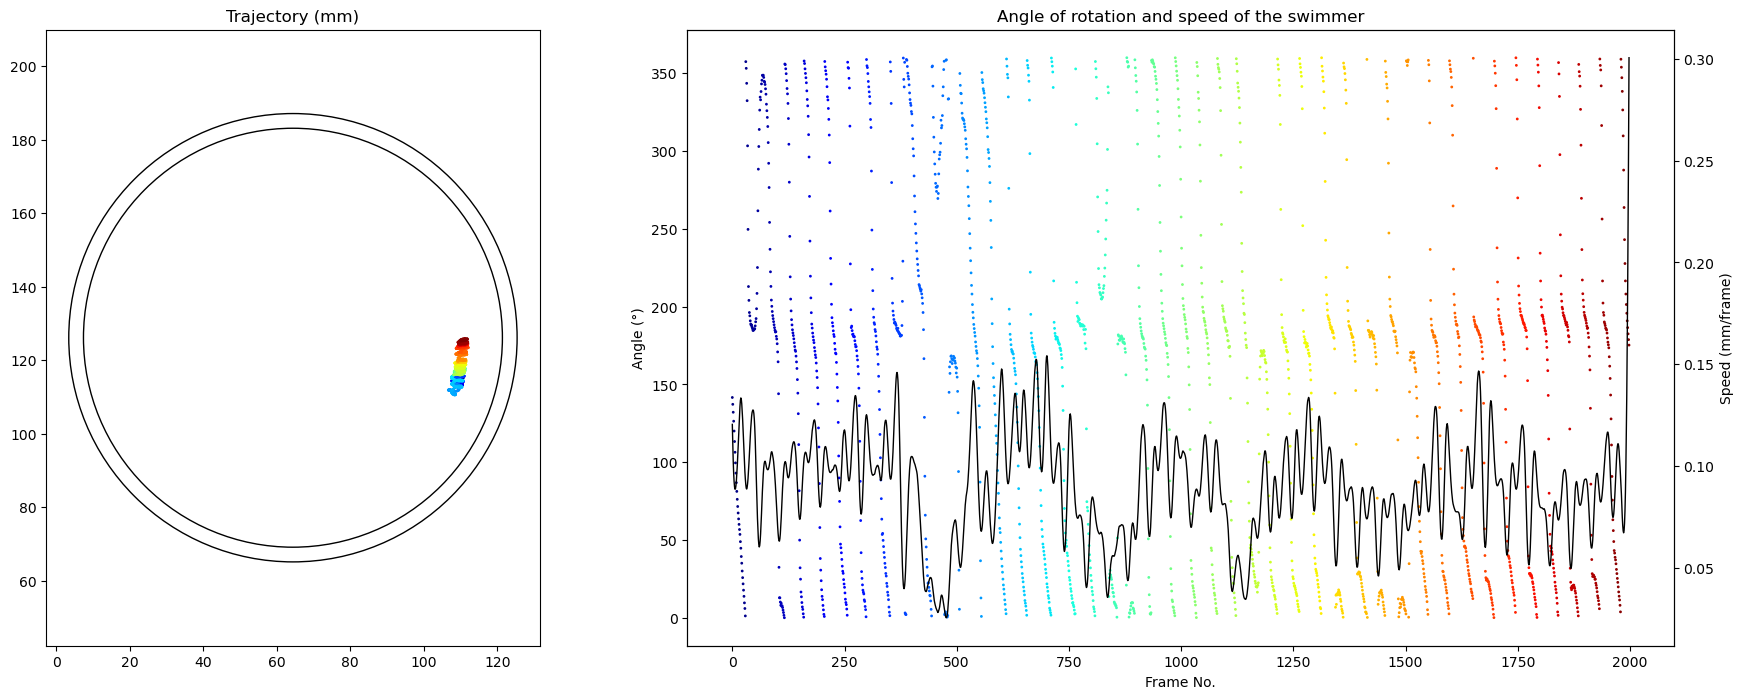

In [54]:
%matplotlib inline

C3 = plt.Circle(((ave_minrow+pool_diam_px/2)/px2mm, (ave_mincol+pool_diam_px/2)/px2mm), radius=pool_diam_px/2/px2mm, fill=False)
C4 = plt.Circle(((ave_minrow+pool_diam_px/2)/px2mm, (ave_mincol+pool_diam_px/2)/px2mm), radius=pool_diam_px/2/px2mm -4, fill=False)

sec = slice(init,fin)

spost_x = savgol_filter(np.diff(x_c[exp_num][sec]),35,3)
spost_y = savgol_filter(np.diff(y_c[exp_num][sec]),35,3)
junkx = np.diff(x_c[exp_num][sec])
junky = np.diff(y_c[exp_num][sec])

sp = np.sqrt(spost_x**2 + spost_y**2)/px2mm
sp_old = sp.copy()
speed_vals = speed_filter(sp, thr=2/px2mm)

angle_vals = []
for rr in range((fin-init)-1):
    if (spost_x[rr] >= 0 and spost_y[rr] >= 0):
        angle_vals.append(np.arctan(spost_y[rr]/(spost_x[rr])))
    elif (spost_x[rr] > 0 and spost_y[rr] < 0):
        angle_vals.append(2*np.pi - np.arctan(np.abs(spost_y[rr])/(np.abs(spost_x[rr]))))
    elif (spost_x[rr] < 0 and spost_y[rr] > 0):
        angle_vals.append(np.pi - np.arctan(np.abs(spost_y[rr])/(np.abs(spost_x[rr]))))
    else:
        angle_vals.append(np.pi + np.arctan(np.abs(spost_y[rr])/(np.abs(spost_x[rr]))))

angle_vals = np.asarray(angle_vals)*180/np.pi

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(21,8), gridspec_kw={'width_ratios':[1,2]})
ax1.add_patch(C3)
ax1.add_patch(C4)
ax1.scatter(x_c[exp_num][sec]/px2mm, y_c[exp_num][sec]/px2mm, c=range(len(x_c[exp_num][sec])), cmap='jet', marker='.', s=4)
ax1.set_title('Trajectory (mm)')
ax2.scatter(range(len(angle_vals)), angle_vals, c=range(len(angle_vals)), cmap='jet', marker='.', s=4)
ax3 = ax2.twinx()
ax3.plot(range(len(speed_vals)), speed_vals, color='k', linewidth=1)
ax2.set_title('Angle of rotation and speed of the swimmer')
ax2.set_ylabel('Angle (°)')
ax3.set_ylabel('Speed (mm/frame)')
ax2.set_xlabel('Frame No.')
#ax3.set_ylim(-0.02,0.1)
#ax2.set_xlim(0,4e3)
ax1.axis('equal')
plt.plot()

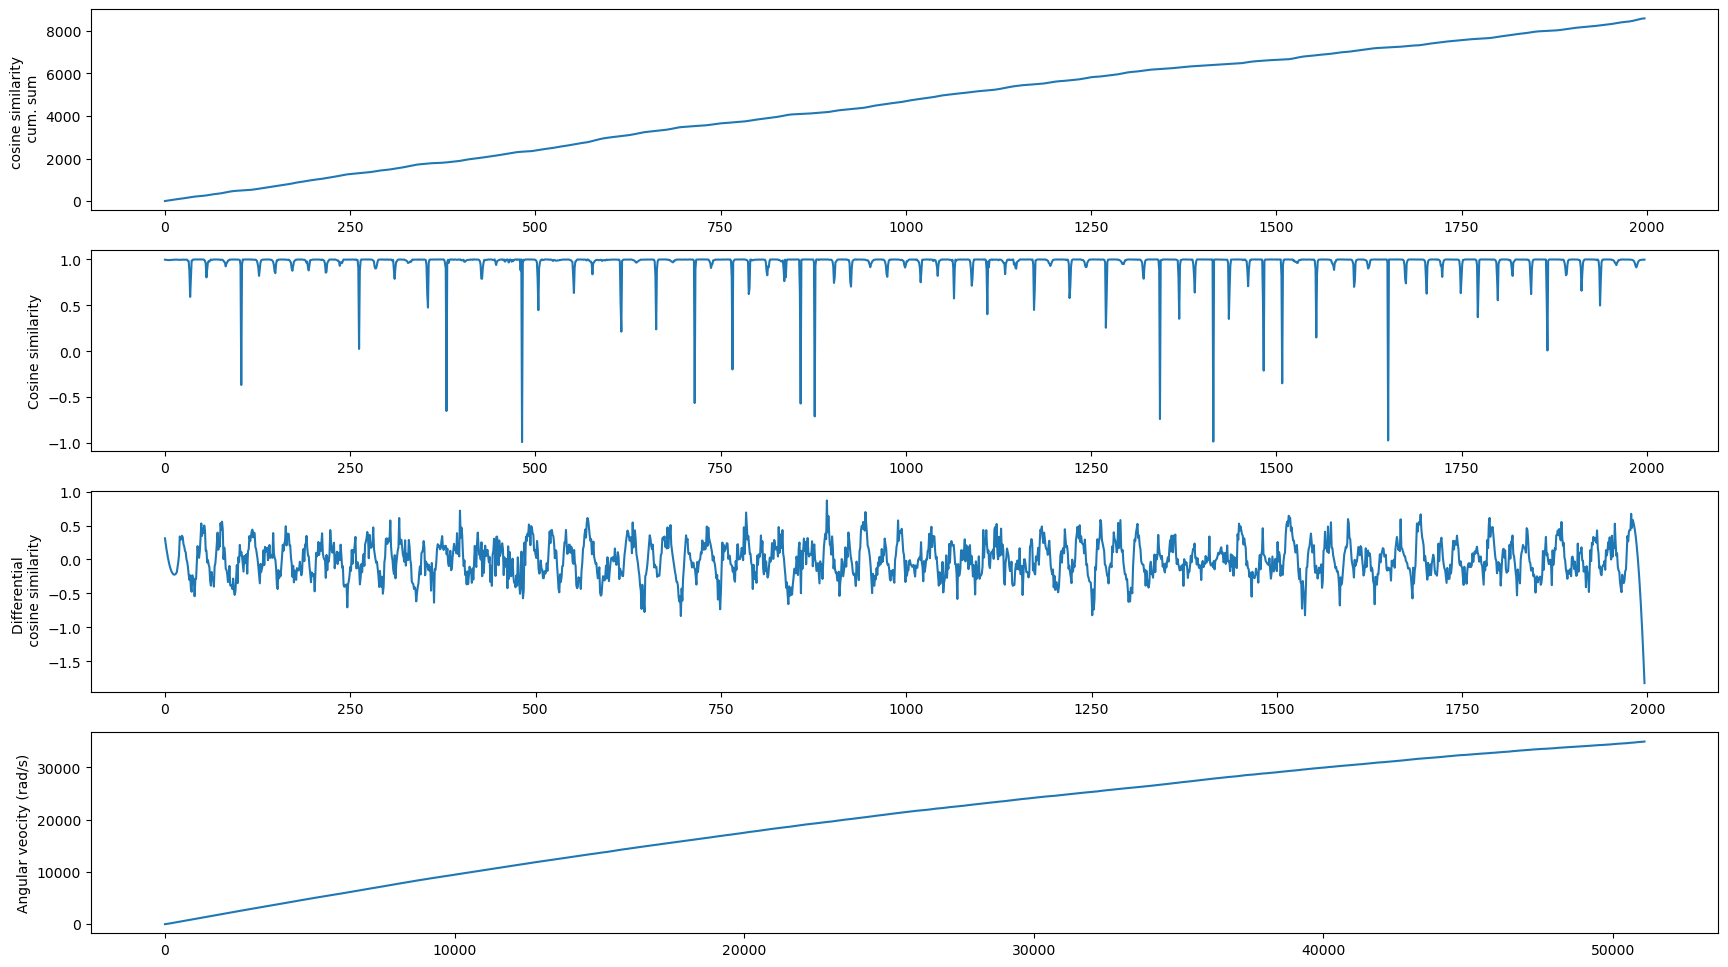

In [52]:
%matplotlib inline
a = []
b = []
for tt in range(fin-init-2):
    a.append([spost_x[tt],spost_y[tt]])
    b.append([spost_x[tt+1],spost_y[tt+1]])

a = np.asarray(a)
b = np.asarray(b)
# find cosine similarity
cosine = np.sum(a*b,axis=1)/ (norm(a,axis=1)*norm(b,axis=1))
cos2ang = np.arccos(cosine)*180/np.pi

cos2ang_old = cos2ang.copy()
cos_out = cosine_filter(cos2ang, filter = True)
#cos_out = cos2ang

var = np.cumsum(cos_out)
span = 20
slopes = []
for tt in range(0,len(var),span):
    slopes.append(stats.linregress(range(len(var[tt:tt+span])), var[tt:tt+span]))

if rototrans:
    fig2, axs2 = plt.subplots(4,1, figsize=(21,12))
    axs2[0].plot(np.cumsum(cos_out))
    axs2[0].set_ylabel('cosine similarity \n cum. sum')
    axs2[1].plot(range(len(cosine)),cosine)
    axs2[1].set_ylabel('Cosine similarity')
    axs2[2].plot(np.diff(cos_out))
    axs2[2].set_ylabel('Differential \n cosine similarity')
    axs2[3].plot(range(len(rotation[exp_num])), np.cumsum(np.abs(rotation[exp_num])/framerate))
    axs2[3].set_ylabel('Angular veocity (rad/s)')
    plt.show()
else:
    fig2, axs2 = plt.subplots(3,1, figsize=(21,12))
    axs2[0].plot(np.cumsum(cos_out))
    axs2[0].set_ylabel('cosine similarity \n cum. sum')
    axs2[1].plot(range(len(cosine)),cosine)
    axs2[1].set_ylabel('Cosine similarity')
    axs2[2].plot(np.diff(cos_out))
    axs2[2].set_ylabel('Differential \n cosine similarity')
    plt.show()
    

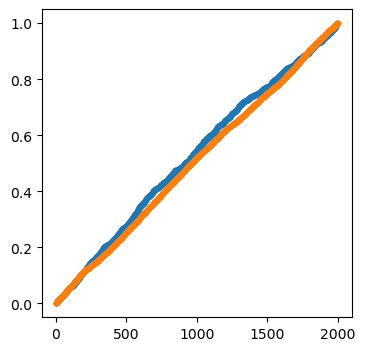

In [53]:
%matplotlib inline
plt.figure(figsize=(4,4))
plt.plot(np.cumsum(cos_out)/np.max(np.cumsum(cos_out)),'.-')
plt.plot(np.cumsum(np.abs(rotation[exp_num][sec])/framerate)/np.max(np.cumsum(np.abs(rotation[exp_num][sec])/framerate)),'.-')
plt.show()

In [56]:
from scipy.fft import fft, fftfreq
from scipy.signal.windows import blackman

In [62]:
N = len(cosine)
T = 1
x = np.linspace(0.0, N*T, N, endpoint=False)
yf = fft(cosine)
w = blackman(N)
ywf = fft(cosine)
xf = fftfreq(N, T)[:N//2]

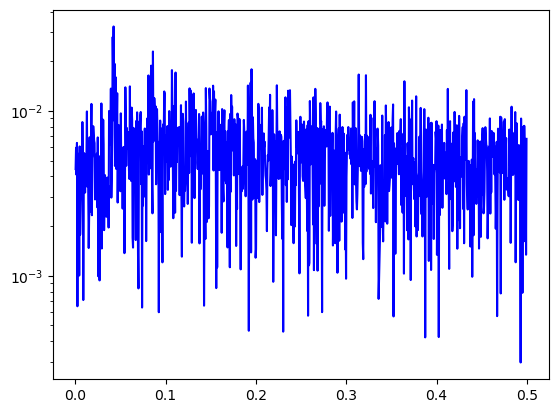

In [63]:
plt.semilogy(xf[1:N//2], 2.0/N * np.abs(yf[1:N//2]), '-b')
plt.show()

[]

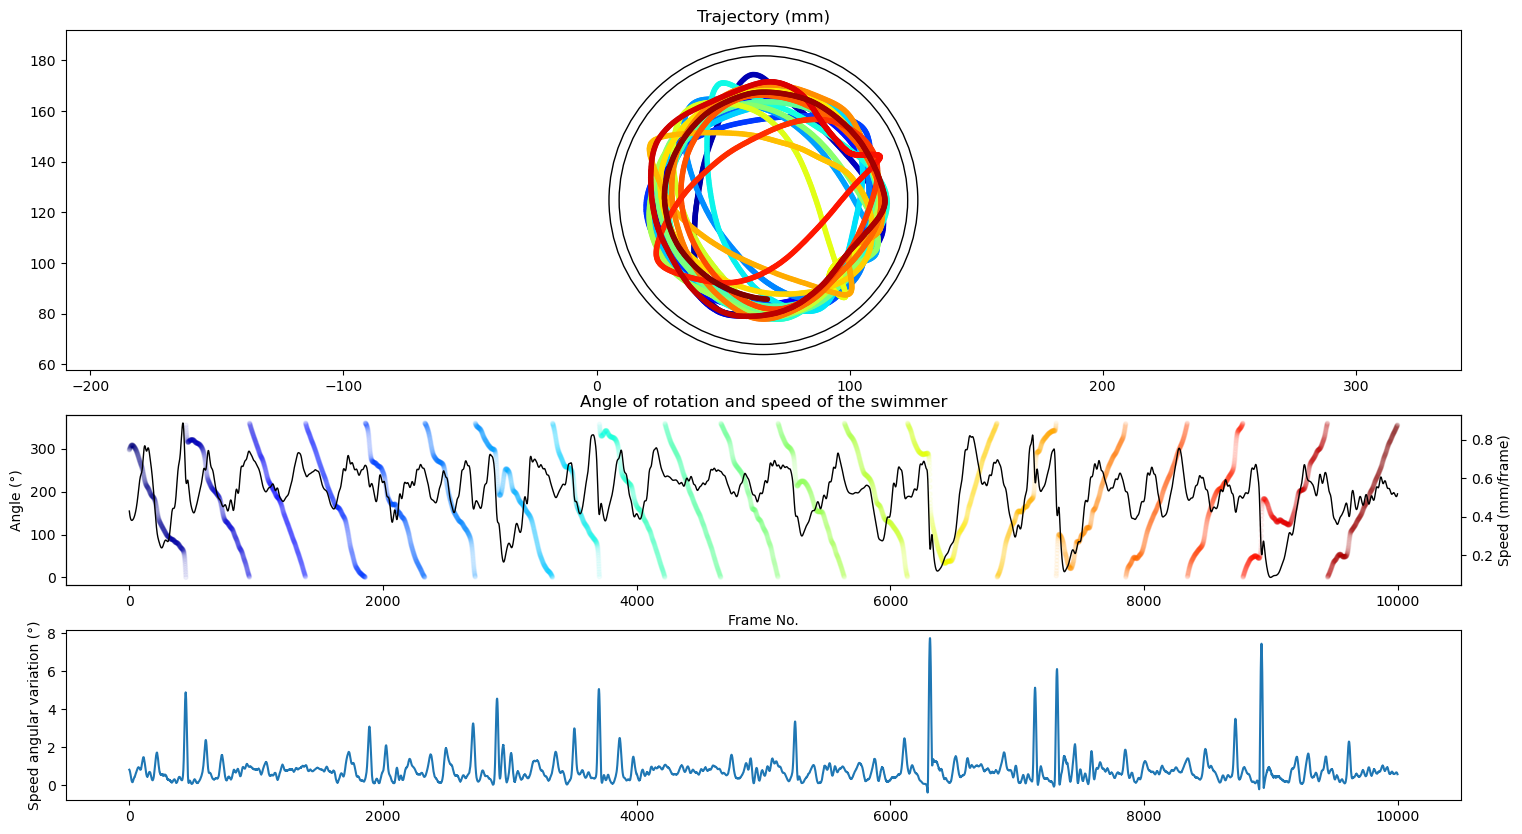

In [65]:
C5 = plt.Circle(((ave_minrow+pool_diam_px/2)/px2mm, (ave_mincol+pool_diam_px/2)/px2mm), radius=pool_diam_px/2/px2mm, fill=False)
C6 = plt.Circle(((ave_minrow+pool_diam_px/2)/px2mm, (ave_mincol+pool_diam_px/2)/px2mm), radius=pool_diam_px/2/px2mm -4, fill=False)

fig, (ax1,ax2, ax4) = plt.subplots(3,1, figsize=(18,10), gridspec_kw={'height_ratios':[2,1,1]})
ax1.add_patch(C5)
ax1.add_patch(C6)
ax1.scatter(x_c[exp_num][sec]/px2mm, y_c[exp_num][sec]/px2mm, c=range(len(x_c[exp_num][sec])), cmap='jet', marker='.')
ax1.set_title('Trajectory (mm)')
ax2.scatter(range(len(angle_vals)), angle_vals, c=range(len(angle_vals)), cmap='jet', marker='.', alpha=0.05)
ax3 = ax2.twinx()
ax3.plot(range(len(speed_vals)), speed_vals, color='k', linewidth=1)
ax4.plot(cos_out)
ax2.set_title('Angle of rotation and speed of the swimmer')
ax2.set_ylabel('Angle (°)')
ax3.set_ylabel('Speed (mm/frame)')
ax4.set_ylabel('Speed angular variation (°)')
ax2.set_xlabel('Frame No.')
#ax3.set_ylim(-0.02,0.1)
#ax2.set_xlim(0,4e3)
ax1.axis('equal')
plt.plot()